# Boiler Plate

In [1]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns
from scipy.cluster import hierarchy as hc


In [22]:
#print score print out rmse, and r2 score
def print_score(m,Xtrn=X_trn,ytrn=y_trn,Xval=X_val,yval=y_val):
    res = [mean_squared_error(m.predict(Xtrn), ytrn),
           mean_squared_error(m.predict(Xval), yval), 
           m.score(Xtrn, ytrn),
           m.score(Xval, yval)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print('Training loss \t Val loss \t Train R2 \t Val R2')
    print(res)
    return res

In [21]:
def plot_score(m,res,val=False):
    
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    if val:
        x = ['train','val','test']
        c = ['royalblue','orange','red']
        res = np.insert(res,2,mean_squared_error(m.predict(X_test),y_test))
        res = np.append(res,m.score(X_test,y_test))
        print(res)
    else:
        x = ['train', 'test']
        c = ['royalblue','red']

    ax[0].bar(x=x, height=res[:len(x)],width=0.5,edgecolor ='black',color =c)
    ax[0].set_title('RMSE loss')
    
    for i in range(len(x)):
        ax[0].text(s=f'{res[i].round(2)}',x=i, y=res[i].round(2)*0.7,horizontalalignment='center')
  
    ax[1].bar(x=x, height=res[len(x):],width=0.5,edgecolor ='black',color =c)
    ax[1].set_title('R2 Score')
    
    for i in range(len(x)):
        ax[1].text(s=f'{res[len(x)+i].round(2)}',x=i, y=res[len(x)+i].round(2)*0.7,horizontalalignment='center')
    

In [8]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Raw Data

In [9]:
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
combine = combine.set_index('Year-Month')
combine['State'] = combine['State'].astype('category')
combine.head()

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  \
Year-Month                                                              
1990-01-01  1990      1    AL   2070.09    820.42   2099.55     53.95   
1990-01-01  1990      1    AR   1026.32    474.99    782.49     47.60   
1990-01-01  1990      1    AZ   1396.50   1081.79    809.80    151.06   
1990-01-01  1990      1    CA   6168.01   6011.77   4454.66    869.56   
1990-01-01  1990      1    CO   1046.80   1158.96    545.39     58.78   

            Sale_ALL  Price_RES  Price_COM  ...     Cus_ALL  Heating_deg_days  \
Year-Month                                  ...                                 
1990-01-01   5044.01       5.96       6.64  ...   1893424.0             517.0   
1990-01-01   2331.40       7.06       6.52  ...   1143435.0             620.0   
1990-01-01   3439.15       7.83       7.64  ...   1606060.0             523.0   
1990-01-01  17504.01       9.68       8.46  ...  11962235.0             552.0   
1990-01-01   2809.94       6.81       5.62  ...   1612736.0            1144.0   

            Cooling_deg_days        Pop    Income   UR       GSP    CPI  \
Year-Month                                                                
1990-01-01              21.0   4036.801   64029.4  6.7   71085.0  132.0   
1990-01-01               5.0   2347.535   34283.2  6.7   38109.0  132.0   
1990-01-01               0.0   3668.417   63546.7  5.2   69322.0  132.0   
1990-01-01               0.0  29863.502  640724.9  5.2  788322.0  132.0   
1990-01-01               0.0   3294.308   65348.5  5.4   74206.0  132.0   

                        Regions  Sale_ALL_no_OTH  
Year-Month                                        
1990-01-01  East South Central           4990.06  
1990-01-01  West South Central           2283.80  
1990-01-01            Mountain           3288.09  
1990-01-01  Pacific Contiguous          16634.44  
1990-01-01            Mountain           2751.15  

[5 rows x 32 columns]

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


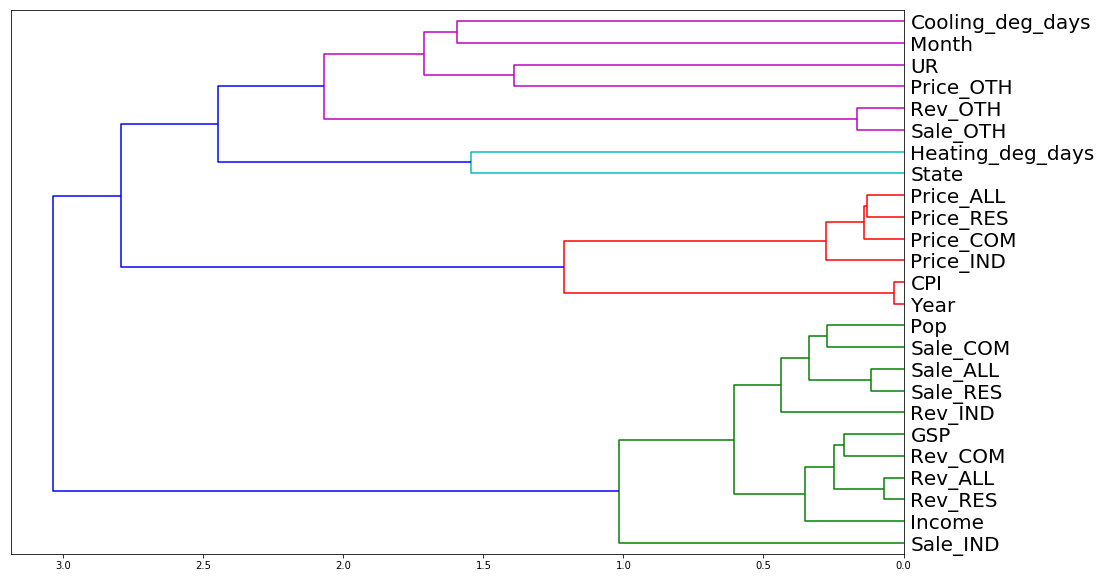

In [78]:
from scipy.cluster import hierarchy as hc

# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(raw).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=raw.columns, orientation='left', leaf_font_size=20)
plt.show()

In [79]:
raw.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI'],
      dtype='object')

Divide sale, rev, income, and gsp by population 

In [43]:
raw['Sale_RES_norm'] = raw['Sale_RES']/raw['Pop']
raw['Sale_COM_norm'] = raw['Sale_COM']/raw['Pop']
raw['Sale_IND_norm'] = raw['Sale_IND']/raw['Pop']
raw['Sale_ALL_norm'] = raw['Sale_ALL']/raw['Pop']

raw['Rev_RES_norm'] = raw['Rev_RES']/raw['Pop']
raw['Rev_COM_norm'] = raw['Rev_COM']/raw['Pop']
raw['Rev_IND_norm'] = raw['Rev_IND']/raw['Pop']
raw['Rev_ALL_norm'] = raw['Rev_ALL']/raw['Pop']

raw['Income_norm'] = raw['Income']/raw['Pop']
raw['GSP_norm'] = raw['GSP']/raw['Pop']

In [44]:
raw.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI', 'Sale_RES_norm', 'Sale_COM_norm', 'Sale_IND_norm',
       'Sale_ALL_norm', 'Rev_RES_norm', 'Rev_COM_norm', 'Rev_IND_norm',
       'Rev_ALL_norm', 'Income_norm', 'GSP_norm'],
      dtype='object')

In [45]:
df_norm = df[['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days', 'Pop',
       'UR', 'CPI', 'Sale_RES_norm', 'Sale_COM_norm', 'Sale_IND_norm',
       'Rev_RES_norm', 'Rev_COM_norm', 'Rev_IND_norm', 'Income_norm',
       'GSP_norm', 'Sale_ALL_norm', 'Rev_ALL_norm']]

In [11]:
df_norm.to_csv(cleanfolder+'combine_norm.csv')

# ML

Machine learning step for each sector :
1. Split the data into train, validation and test set
2. Use random forest regression to select feature by feature of important 
3. Create a dendogram and look for redundant  feature to remove
3. Feel the selected feature into TPOT to search for the best model 
4. Train the model on the training+validation set and predict on the test set
4. Implement the model on the 


In [14]:
def three_split(df,y):
    '''split data into train, validation and test '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    val_idxs = int(df.shape[0]*0.85*0.75)
    
    X_trn = df.iloc[:val_idxs]
    y_trn = y[:val_idxs]

    X_val = df.iloc[val_idxs:test_idxs]
    y_val = y[val_idxs:test_idxs]
    
    return (X_trn,y_trn,X_val,y_val,X_test,y_test)

In [15]:
def two_split(df,y):
    '''split data into train, validation and test '''
     
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    
    X_trn = df.iloc[:test_idxs]
    y_trn = y[:test_idxs]
    
    return (X_trn,y_trn,X_test,y_test)

In [16]:
def do_search(X_trn,y_trn):
    ''' randomize search for randomforest regressor
    return the best estimator'''
    # rf 
    m = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,X_trn.shape[1]),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}
    
    #hyper parameter tuning
    search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=40)
    
    search.fit(X_trn,y_trn)
    print(search.best_params_, search.best_score_)
    
    return search.best_estimator_

In [17]:
def make_dedo(df):
    
    
    # Redundant Features
    corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))
    
    for i in range(corr.shape[0]):
        corr[i,i] = 1
    
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    fig = plt.figure(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
    plt.show()

In [200]:
#print score print out rmse, and r2 score
def print_score(m,Xtrn=X_trn,ytrn=y_trn,Xval=X_val,yval=y_val):
    res = [mean_squared_error(m.predict(Xtrn), ytrn),
           mean_squared_error(m.predict(Xval), yval), 
           m.score(Xtrn, ytrn),
           m.score(Xval, yval)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print('Training loss \t Val loss \t Train R2 \t Val R2')
    print(res)
    return res

In [18]:
def plot_score(m,res,val=False):
    
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    if val:
        x = ['train','val','test']
        c = ['royalblue','orange','red']
        res = np.insert(res,2,mean_squared_error(m.predict(X_test),y_test))
        res = np.append(res,m.score(X_test,y_test))
        print(res)
    else:
        x = ['train', 'test']
        c = ['royalblue','red']

    ax[0].bar(x=x, height=res[:len(x)],width=0.5,edgecolor ='black',color =c)
    ax[0].set_title('RMSE loss')
    
    for i in range(len(x)):
        ax[0].text(s=f'{res[i].round(2)}',x=i, y=res[i].round(2)*0.7,horizontalalignment='center')
  
    ax[1].bar(x=x, height=res[len(x):],width=0.5,edgecolor ='black',color =c)
    ax[1].set_title('R2 Score')
    
    for i in range(len(x)):
        ax[1].text(s=f'{res[len(x)+i].round(2)}',x=i, y=res[len(x)+i].round(2)*0.7,horizontalalignment='center')
    

In [10]:
# load the data 
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')
combine.head()

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  Sale_ALL  \
1  1990      1    AL   2070.09    820.42   2099.55     53.95   5044.01   
2  1990      1    AR   1026.32    474.99    782.49     47.60   2331.40   
3  1990      1    AZ   1396.50   1081.79    809.80    151.06   3439.15   
4  1990      1    CA   6168.01   6011.77   4454.66    869.56  17504.01   
5  1990      1    CO   1046.80   1158.96    545.39     58.78   2809.94   

   Price_RES  Price_COM  ...  Heating_deg_days  Cooling_deg_days        Pop  \
1       5.96       6.64  ...             517.0              21.0   4036.801   
2       7.06       6.52  ...             620.0               5.0   2347.535   
3       7.83       7.64  ...             523.0               0.0   3668.417   
4       9.68       8.46  ...             552.0               0.0  29863.502   
5       6.81       5.62  ...            1144.0               0.0   3294.308   

     Income   UR       GSP    CPI              Regions  Year-Month  \
1   64029.4  6.7   71085.0  132.0  East South Central   1990-01-01   
2   34283.2  6.7   38109.0  132.0  West South Central   1990-01-01   
3   63546.7  5.2   69322.0  132.0            Mountain   1990-01-01   
4  640724.9  5.2  788322.0  132.0  Pacific Contiguous   1990-01-01   
5   65348.5  5.4   74206.0  132.0            Mountain   1990-01-01   

   Sale_ALL_no_OTH  
1          4990.06  
2          2283.80  
3          3288.09  
4         16634.44  
5          2751.15  

[5 rows x 33 columns]

In [193]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI', 'Regions', 'Year-Month'],
      dtype='object')

**Industry**

In [11]:
#predict column 
pre_col = 'Sale_IND'
use_col = ['Year', 'Month', 'State','Price_IND', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions']

skip_col = [x for x in combine.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

NameError: name 'raw' is not defined

In [127]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 29, 'max_depth': None, 'bootstrap': True} 0.9767953417895711


In [128]:
m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[1665.5929062480318, 149538.86549569757, 0.9993460032330438, 0.9358186765710147]


[  1665.59291 149538.8655  269593.11012      0.99935      0.93582      0.89586]


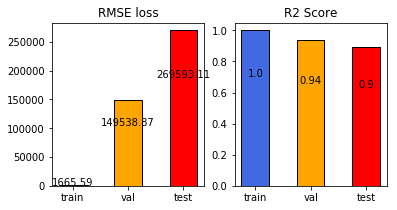

In [129]:
plot_score(m,res,val=True)

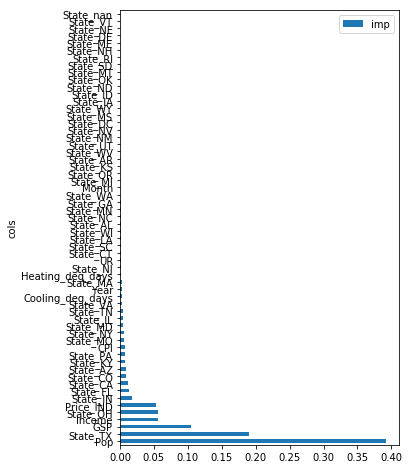

In [130]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**RES**

In [19]:
#predict column 
pre_col = 'Sale_RES'
use_col = ['Year', 'Month', 'State','Cus_RES','Price_RES', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI']

skip_col = [x for x in combine.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
#df, y, nas, mapper = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49)

In [23]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)


KeyboardInterrupt: 

In [24]:
result = print_score(m,X_trn,y_trn,X_val,y_val)

[1663.3457599321143, 181249.59272007082, 0.9995720512069085, 0.9683780260081978]


[  1663.34576 181249.59272 313638.58057      0.99957      0.96838      0.95081]


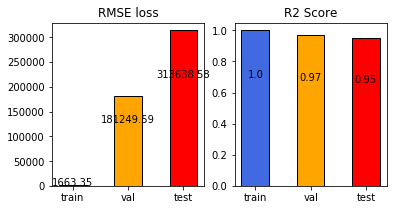

In [25]:
plot_score(m,result,val=True)

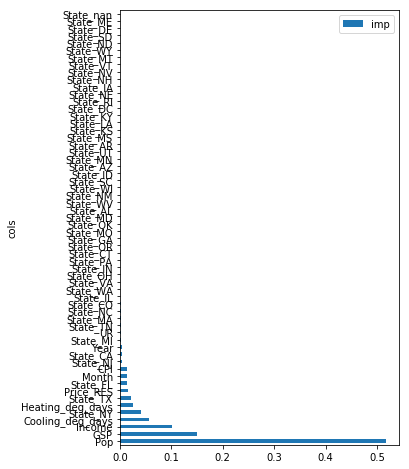

In [134]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**COM**

In [135]:
#predict column 
pre_col = 'Sale_COM'
use_col = ['Year', 'Month', 'State','Price_COM', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(raw, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [136]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 21, 'max_depth': None, 'bootstrap': False} 0.9839529259404468
[1276.6279100469972, 129461.56308717551, 0.9995968993768851, 0.975692302497621]


[  1276.62791 129461.56309 355590.55433      0.9996       0.97569      0.93797]


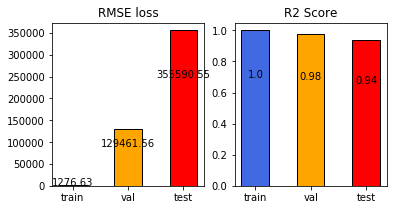

In [137]:
plot_score(m,res,val=True)

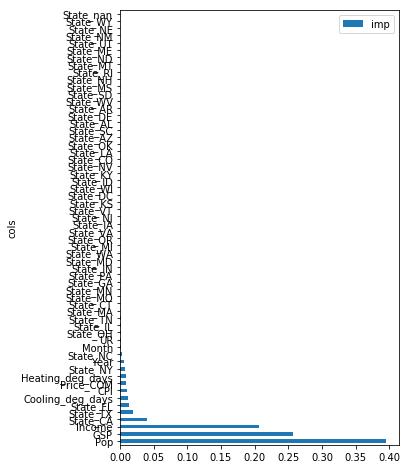

In [138]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**ALL**

In [140]:
#predict column 
pre_col = 'Sale_ALL'
use_col = ['Year', 'Month', 'State','Price_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'InALLe',
       'UR', 'GSP', 'CPI']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(raw, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [141]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 24, 'max_depth': None, 'bootstrap': False} 0.9873473563922713
[8931.906567018132, 1081008.879191711, 0.9996562359537922, 0.9684027103684252]


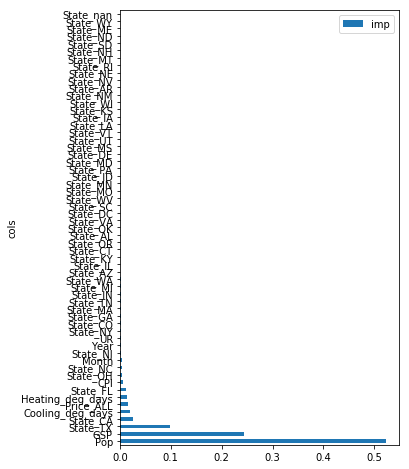

In [142]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**Other**

In [164]:
#predict column 
pre_col = 'Sale_OTH'
use_col = ['Year', 'Month', 'State','Price_OTH', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'InALLe',
       'UR', 'GSP', 'CPI']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(raw, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [165]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 58, 'max_depth': None, 'bootstrap': True} 0.9514831638652594
[142.5482813148414, 28.145803962073938, 0.997254110567483, 0.9797506651537635]


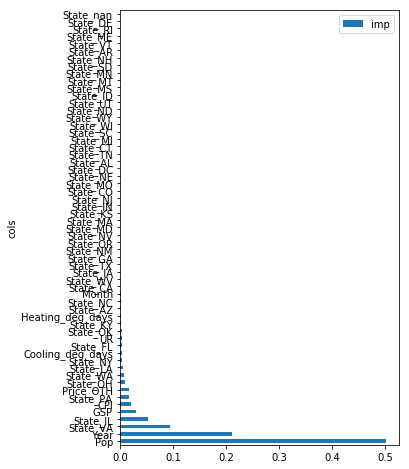

In [166]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

# ML on data divied by population

In [146]:
df_norm = pd.read_csv(cleanfolder+'combine_norm.csv')
df_norm['Year-Month'] = pd.to_datetime(df_norm['Year-Month'])
df_norm['State'] = df_norm['State'].astype('category')

In [147]:
df_norm.columns

Index(['Year-Month', 'Year', 'Month', 'State', 'Heating_deg_days',
       'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP', 'CPI',
       'Sale_RES_norm', 'Sale_COM_norm', 'Sale_IND_norm', 'Rev_RES_norm',
       'Rev_COM_norm', 'Rev_IND_norm', 'Income_norm', 'GSP_norm',
       'Sale_ALL_norm', 'Rev_ALL_norm'],
      dtype='object')

**Industry**

In [148]:
#predict column 
pre_col = 'Sale_IND_norm'
use_col = ['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [149]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

{'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 16, 'max_depth': None, 'bootstrap': False} 0.9095592629649045


In [150]:
m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[0.0002249719885567358, 0.009779507456600162, 0.9953117008413904, 0.826522860392912]


[0.00022 0.00978 0.0288  0.99531 0.82652 0.52762]


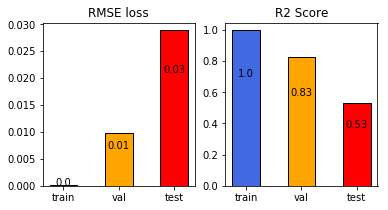

In [151]:
plot_score(m,res,val=True)

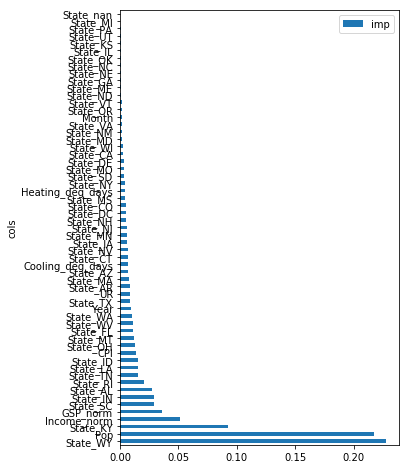

In [152]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**RES**

In [153]:
#predict column 
pre_col = 'Sale_RES_norm'
use_col = ['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, RESicate the target column
# one hot encode the wRES column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [154]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 29, 'max_depth': None, 'bootstrap': False} 0.9007738606124772
[3.144356930183455e-05, 0.002282776417391126, 0.9980695256298169, 0.8817908788509438]


[0.00003 0.00228 0.00243 0.99807 0.88179 0.85774]


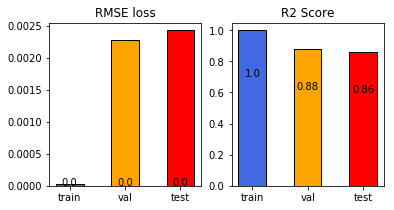

In [155]:
plot_score(m,res,val=True)

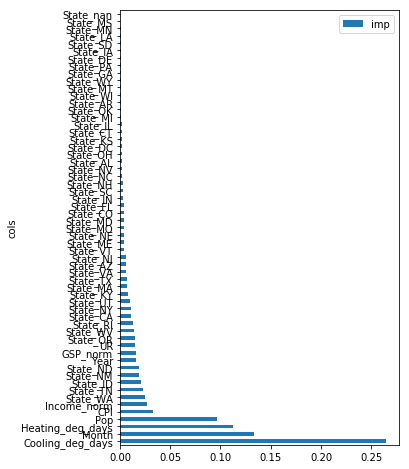

In [156]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**COM**

In [157]:
#predict column 
pre_col = 'Sale_COM_norm'
use_col = ['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, COMicate the target column
# one hot encode the wCOM column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [158]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 40, 'max_depth': None, 'bootstrap': False} 0.7632567609262076
[4.583181424531159e-05, 0.0012821248636604916, 0.9973861725644603, 0.9396598266510121]


[0.00005 0.00128 0.00317 0.99739 0.93966 0.79646]


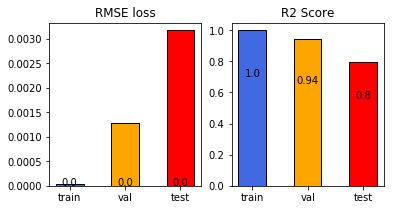

In [159]:
plot_score(m,res,val=True)

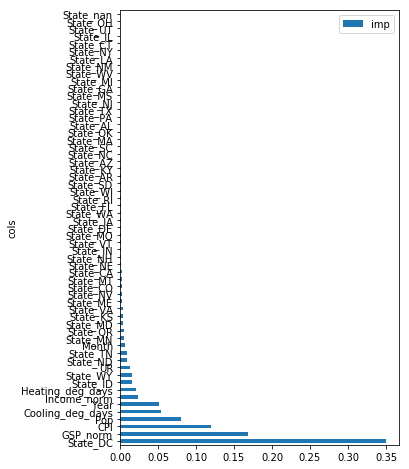

In [160]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**ALL**

In [161]:
#predict column 
pre_col = 'Sale_ALL_norm'
use_col = ['Year', 'Month', 'State', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, ALLicate the target column
# one hot encode the wALL column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [162]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 30, 'max_depth': None, 'bootstrap': True} 0.9009636423785565
[0.0003907090212140426, 0.02236301670738352, 0.9964688030761446, 0.8359406212720608]


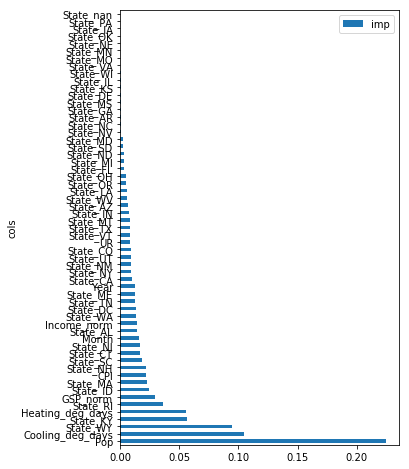

In [163]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

# Predicting Revenue 

In [168]:
combine.head()

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  \
Year-Month                                                              
1990-01-01  1990      1    AL   2070.09    820.42   2099.55     53.95   
1990-01-01  1990      1    AR   1026.32    474.99    782.49     47.60   
1990-01-01  1990      1    AZ   1396.50   1081.79    809.80    151.06   
1990-01-01  1990      1    CA   6168.01   6011.77   4454.66    869.56   
1990-01-01  1990      1    CO   1046.80   1158.96    545.39     58.78   

            Sale_ALL  Price_RES  Price_COM  ...  Rev_IND  Rev_OTH  Rev_ALL  \
Year-Month                                  ...                              
1990-01-01   5044.01       5.96       6.64  ...    87.76     2.85   268.44   
1990-01-01   2331.40       7.06       6.52  ...    37.05     3.12   143.64   
1990-01-01   3439.15       7.83       7.64  ...    43.27     7.83   243.13   
1990-01-01  17504.01       9.68       8.46  ...   268.76    32.10  1406.54   
1990-01-01   2809.94       6.81       5.62  ...    24.49     4.05   165.00   

            Heating_deg_days  Cooling_deg_days        Pop    Income   UR  \
Year-Month                                                                 
1990-01-01             517.0              21.0   4036.801   64029.4  6.7   
1990-01-01             620.0               5.0   2347.535   34283.2  6.7   
1990-01-01             523.0               0.0   3668.417   63546.7  5.2   
1990-01-01             552.0               0.0  29863.502  640724.9  5.2   
1990-01-01            1144.0               0.0   3294.308   65348.5  5.4   

                 GSP    CPI  
Year-Month                   
1990-01-01   71085.0  132.0  
1990-01-01   38109.0  132.0  
1990-01-01   69322.0  132.0  
1990-01-01  788322.0  132.0  
1990-01-01   74206.0  132.0  

[5 rows x 25 columns]

Industry

In [172]:
#predict column 
pre_col = 'Rev_IND'
use_col = ['Year', 'Month', 'State','Price_IND', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(raw, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [173]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 21, 'max_depth': None, 'bootstrap': False} 0.9637381218431543
[3.631330477476763, 1851.8957579841795, 0.99954387041522, 0.843918564666722]


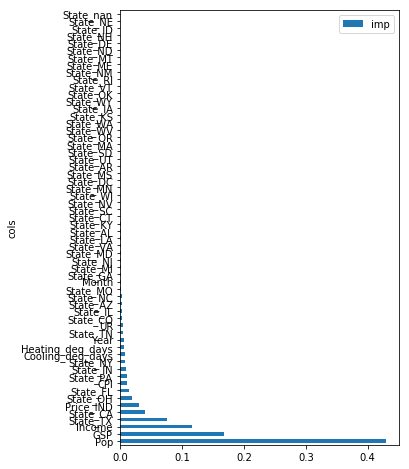

In [174]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

**Rev Resident norm**

In [181]:
#predict column 
pre_col = 'Rev_RES_norm'
use_col = ['Year', 'Month', 'State', 'Price_RES','Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, RESicate the target column
# one hot encode the wRES column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [182]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 24, 'max_depth': None, 'bootstrap': False} 0.7942999734136372
[4.663308672837927e-07, 7.152842696514317e-05, 0.9953507665899035, 0.5653411923840903]


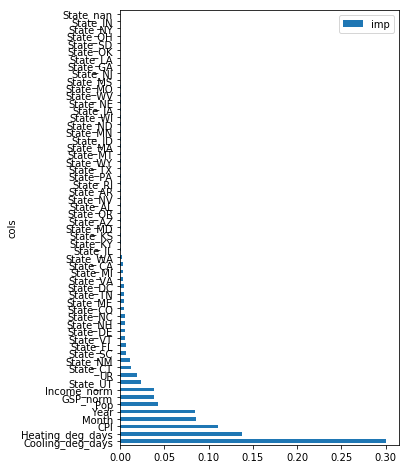

In [183]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

Commercial 

In [184]:
#predict column 
pre_col = 'Rev_COM_norm'
use_col = ['Year', 'Month', 'State','Price_COM', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income_norm',
       'UR', 'GSP_norm', 'CPI']

skip_col = [x for x in df_norm.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, COMicate the target column
# one hot encode the wCOM column with 49 catergory
df, y, nas, mapper = proc_df(df_norm, pre_col,skip_flds=skip_col, max_n_cat=49,do_scale=True)

In [185]:
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m = do_search(X_trn,y_trn)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 29, 'max_depth': None, 'bootstrap': False} 0.7677320429418538
[3.541073824889557e-07, 5.698387847105088e-05, 0.9977860447959245, 0.8442694628559815]


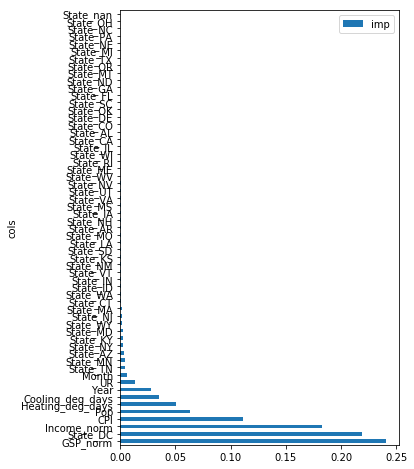

In [186]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

# Predicting Sale_RES

In [50]:
data_df = df_norm[['Year-Month', 'Year', 'Month', 'State', 'Heating_deg_days', 'Pop',
       'Cooling_deg_days','Sale_RES_norm','Income_norm', 'GSP_norm']]

In [51]:
#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(data_df, 'Sale_RES_norm',max_n_cat=49, skip_flds=['Year-Month'],do_scale=True)

In [52]:
test_idxs = int(df.shape[0]*0.85)
X_test = df.iloc[test_idxs:]
y_test = y[test_idxs:]

val_idxs = int(df.shape[0]*0.85*0.75)

X_trn = df.iloc[:val_idxs]
y_trn = y[:val_idxs]

X_val = df.iloc[val_idxs:test_idxs]
y_val = y[val_idxs:test_idxs]

(array([725737.00001, 727198.00001, 728659.00001, 730120.00001, 731581.00001, 733042.00001, 734503.00001,
        735964.00001, 737425.00001]), <a list of 9 Text xticklabel objects>)

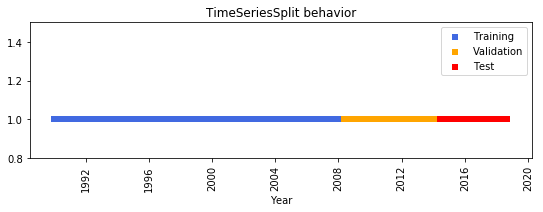

In [53]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)
date = df_norm['Year-Month']

fig, ax = plt.subplots(figsize=(9, 2.5))
# Plot training and test indices
l1 = ax.scatter(date.iloc[X_trn.index], [1] * len(y_trn), c='royalblue', marker='_', lw=6)
l2 = ax.scatter(date.iloc[X_val.index], [1] * len(y_val), c='orange', marker='_', lw=6)
l3 = ax.scatter(date.iloc[X_test.index], [1] * len(y_test), c='red', marker='_', lw=6)
ax.legend([l1, l2, l3], ['Training', 'Validation','Test'])
ax.set(ylim=[0.8, 1.5], title='TimeSeriesSplit behavior', xlabel='Year')
plt.xticks(rotation=90)

Use the training and validation set for hyper parameter tuning and feature selection. Retrain the train+validation together and test on the test set.

## Random Forrest Regressor

In [55]:
# rf 
m = RandomForestRegressor(n_jobs=-1, random_state=42)

param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,14),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}

#hyper parameter tuning
search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=40)

search.fit(X_trn,y_trn)
search.best_params_, search.best_score_

({'n_estimators': 40,
  'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_features': 12,
  'max_depth': None,
  'bootstrap': False},
 0.8910203645963756)

In [54]:
# rf after hyper parameter tuning
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_split= 10,
                          min_samples_leaf= 1,
                          max_features= 12,
                          max_depth= None, 
                          bootstrap= False,
                          n_jobs=-1, random_state=42)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[0.00020623629389608796, 0.0018517564418465606, 0.9873381461326424, 0.9041104070003714]


Rerun the rf model using these parameters.

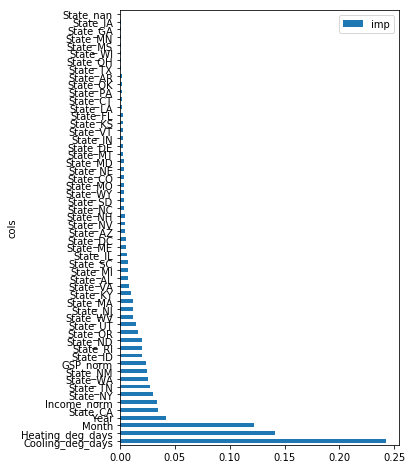

In [37]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

In [71]:
to_drop = fi[fi.imp <0.05].cols
df = df.drop(to_drop,axis=1)

In [72]:
df.columns

Index(['Month', 'Heating_deg_days', 'Pop', 'Cooling_deg_days'], dtype='object')

In [58]:
# drop features with low importance 
to_drop = fi[fi.imp <0.05].cols
df = df.drop(to_drop,axis=1)

#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 49 catergory
df, y, nas, mapper = proc_df(data_df, 'Sale_RES_norm',max_n_cat=49, skip_flds=['Year-Month'],do_scale=True)

test_idxs = int(df.shape[0]*0.85)
X_test = df.iloc[test_idxs:]
y_test = y[test_idxs:]

val_idxs = int(df.shape[0]*0.85*0.75)

X_trn = df.iloc[:val_idxs]
y_trn = y[:val_idxs]

X_val = df.iloc[val_idxs:test_idxs]
y_val = y[val_idxs:test_idxs]

In [59]:
# rf after hyper parameter tuning
m = RandomForestRegressor(n_estimators=40, 
                          min_samples_split= 10,
                          min_samples_leaf= 1,
                          max_features= 12,
                          max_depth= None, 
                          bootstrap= False,
                          n_jobs=-1, random_state=42)

m.fit(X_trn,y_trn)
res = print_score(m,X_trn,y_trn,X_val,y_val)

[0.000206236293896088, 0.0018517564418465606, 0.9873381461326424, 0.9041104070003714]


[0.00021 0.00185 0.00223 0.98734 0.90411 0.8695 ]


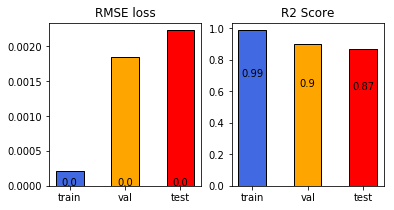

In [60]:
plot_score(m,res,val=True)

(733163.0, 736938.0)

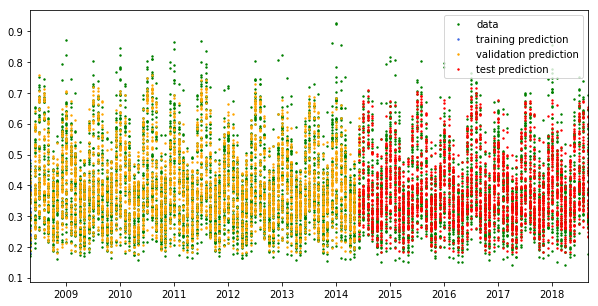

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
l1 = ax.scatter(x=date,y=y,c='green',s=2)
l2 = ax.scatter(x=date.iloc[:val_idxs],y=m.predict(X_trn),c='royalblue',s=2)
l3 = ax.scatter(x=date.iloc[val_idxs:test_idxs],y=m.predict(X_val),c='orange',s=2)
l4 = ax.scatter(x=date.iloc[test_idxs:],y=m.predict(X_test),c='red',s=2)

ax.legend([l1, l2, l3, l4], ['data', 'training prediction',
                         'validation prediction','test prediction'])

plt.xlim([date.iloc[val_idxs], date.iloc[-1]])

## Auto TPOT RES


In [65]:
from tpot import TPOTRegressor

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [66]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)
print(tpot.score(X_val, y_val))
tpot.export('tpot_pipeline_sale_res.py')

Generation 1 - Current best internal CV score: -0.001080636816671882
Generation 2 - Current best internal CV score: -0.0007978005493285437
Generation 3 - Current best internal CV score: -0.0007978005493285437
Generation 4 - Current best internal CV score: -0.0007843772682511573
Generation 5 - Current best internal CV score: -0.0007843772682511573

Best pipeline: RidgeCV(ExtraTreesRegressor(ElasticNetCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), l1_ratio=0.25, tol=0.0001), bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=17, min_samples_split=5, n_estimators=100))
-0.002851872613749145


In [67]:
tpot.score(X_val,y_val)

-0.002851872613749145

In [ ]:
#from 'tpot_pipeline_sale_res.py'

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-0.0007843772682511573
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.25, tol=0.0001)),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=17, min_samples_split=5, n_estimators=100)),
    RidgeCV()
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)